# Reduce NOT spectra

Follow the pdf under the docs folder [Reducing Spectra with IRAF](docs/specred.pdf)

The section are following the numberin in the pdf

In [98]:
# Import Matplotlib and astropy to plot the fits files. 
#This can be donw with ds9 easily too

import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import os,glob

#IRAF. Probable there is a better way to do it but it seems to work
from pyraf.iraf import noao
from pyraf.iraf import imred
from pyraf.iraf import ccdred
from pyraf.iraf import ccdproc
from pyraf.iraf import zerocombine
from pyraf.iraf import kpnoslit
from pyraf.iraf import response
from pyraf.iraf import illumination
from pyraf.iraf import imarith, imcombine

# 3 Basic Reductions

# 3.1 Bias

The first step they do is to find an overscan area in the images. Below I plot one of the sources and I assume that the overscan area is on the top from around y=2064 to the top y =2100.

They sat that: "" If you need to use bias iamges and not just overscan, combie the images using command **zerocombine**. [Zerocombine](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?zerocombine) combine and process zero level images.  This task is a script which applies ccdproc and combine

 Ill try to create a master bias with zerocombine

In [2]:
filename = get_pkg_data_filename('SerieCompleta/ALCa220199.fits')

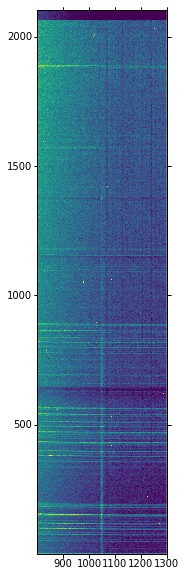

In [29]:
hdu = fits.open(filename)[1]
wcs = WCS(hdu.header)

plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(hdu.data, vmin=11713, vmax=12580,origin='lower')



In [100]:
biaslist = glob.glob('bias/*.fits')
biaslist = [i+'[1]' for i in biaslist]
biaslist = ','.join(x for x in biaslist)
biaslist

'bias/ALCa220372.fits[1],bias/ALCa220373.fits[1],bias/ALCa220380.fits[1],bias/ALCa220375.fits[1],bias/ALCa220371.fits[1],bias/ALCa220378.fits[1],bias/ALCa220374.fits[1],bias/ALCa220379.fits[1],bias/ALCa220377.fits[1],bias/ALCa220370.fits[1],bias/ALCa220376.fits[1]'

This doesnt work if ccdtype is not empty as stated in the tutorial. 

In [103]:
zerocombine(input=biaslist,output='MasterBias.fits',ccdtype='')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


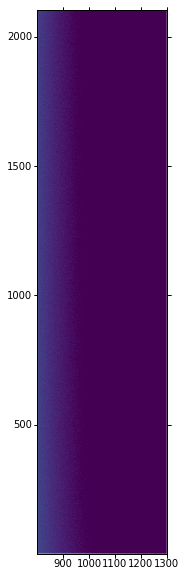

In [110]:
filename = 'MasterBias.fits'
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(hdu.data, vmin=11713, vmax=12580,origin='lower')



# 3.2 Flats

In the folder flatandarc there is a mix of flat or IMAGETYP= 'FLAT,LAMP' "FLAT,LAMP" and IMAGETYP= 'WAVE,LAMP'. Try to do the flat-fleid witg the flat-lamp and the response iraf routine. 

By looking at the header the 'FLAT,LAMP' seem to be from 253-257 in the flats arc folder. 

The 258-260 are 'wave,lamp', but there are also some other wavelamp in each of the primer apuntado y serie compelta



In the tutorial you have to do response and them illium, they say:

> "If you have takend two flat-field images, one before and one after the spectrum, you can combine them by taking an average using **imarith**"

This should probably be done interactively but as s first try I will trdy PyRAF and the defaults

In each of the primer aputnado y serie complete el primer y el segundo son wave,lamp. Supongo para calibrar con esas. En el night report antes del science exposure tienen el adquisicion image. 

In [21]:
filesarcandflats = glob.glob('flatandarc/*.fits')
flatlist = []
for i in filesarcandflats:
    hdu = fits.open(i)[0]
    #print(i)
    typeimage = hdu.header['IMAGETYP']
    if typeimage == 'FLAT,LAMP':
        flatlist.append(i)

        
flatlist = [i+'[1]' for i in flatlist]

#flatlist = ','.join(x for x in flatlist)


## Response

In [34]:
responselist = []
for num,flat in enumerate(flatlist):
    response(calibrat=flat,normaliz=flat,response='resp'+str(num),interactive='no')
    responselist.append('resp'+str(num))
    
    
#response(calibrat=flatlist,normaliz=flatlist,response='FlatMaster.fits')

## Illumination

In [53]:
illulist = []
for num,resp in enumerate(responselist):
    illuname = 'illu'+str(num)
    illumination(images=resp,illumina=illuname,interactive='no')
    illulist.append(illuname)
    

# Correcting the flat-field image

In the tutorial it says to set illumcor=yes and the other corrections no and givwe the illumination image. 

### For some reason I had to do overscan=no to work and fixpix=no

In [90]:
reducelist = []
for num,(resp,illu) in enumerate(zip(responselist,illulist)):
    reducename = 'red'+str(num)
    illufits = illu+'.fits'
    respfits = resp+'.fits'
    #print(illufits)
    ccdproc(illumcor='yes',zerocor='no',darkcor='no',flatcor='no',fringecor='no',readcor='no',scancor='no',fixpix='no',overscan='no',
            illum=illufits,output=reducename,images=resp,ccdtype='')
    reducelist.append(reducename)
    

# imarith and imcombine to combine all the flats. 

Use imcombine to comgbine them . 

In [110]:
reducelist2 = [i+'.fits[1]' for i in reducelist]
reducelist2 =  ','.join(x for x in reducelist2)

illumlist2 = [i+'.fits[1]' for i in illulist]
illumlist2 =  ','.join(x for x in illulist)

imcombine(input=reducelist2,output='FlatMaster.fits',combine='average')
imcombine(input=illumlist2,output='IllumMaster.fits',combine='average')


Feb 12 19:03: IMCOMBINE
  combine = average, scale = none, zero = none, weight = none
  blank = 0.
                Images 
           red0.fits[1]
           red1.fits[1]
           red2.fits[1]
           red3.fits[1]
           red4.fits[1]

  Output image = FlatMaster.fits, ncombine = 5

Feb 12 19:03: IMCOMBINE
  combine = average, scale = none, zero = none, weight = none
  blank = 0.
                Images 
                  illu0
                  illu1
                  illu2
                  illu3
                  illu4

  Output image = IllumMaster.fits, ncombine = 5


# Science Reduction

First try with one exposure and maybe the standard

Again have to use ccdproc to apply the flat-field

> What Illum to use? Probably should combine them but will start with only one.

In [134]:
scienceexposure = 'SerieCompleta/ALCa220200.fits[1]'

ccdproc(images=scienceexposure,ccdtype='',output='ScienceRed.fits',flatcor='no',flat='FlatMaster.fits[1]',illumcor='yes',illum='IllumMaster.fits'
        ,zerocor='no',darkcor='no',fringecor='no',readcor='no',scancor='no',fixpix='no',overscan='no')

In [128]:
! rm ScienceRed.fits

In [130]:
scienceexposure = 'standard/ALCa220207.fits[1]'


ccdproc(images=scienceexposure,ccdtype='',output='ScienceRedStandard.fits',flatcor='no',flat='FlatMaster.fits[1]',illumcor='yes',illum='IllumMaster.fits'
        ,zerocor='no',darkcor='no',fringecor='no',readcor='no',scancor='no',fixpix='no',overscan='no')

# 1D spectra

The standard looks nice after reduce bu hard to find the source in the science re one. By looking at the header and using the object RA and DEC and Angle I got this region file. And from this the width of the slit http://www.not.iac.es/instruments/alfosc/current_setup.php?i=513


![acq](images/acquisition.png)

# Standard reduce

The standars start is: SP0644+375 RA 06:47:36 DEC 37:30:36 and spectral type DA (blue)
[Here](http://www.ing.iac.es/Astronomy/observing/manuals/html_manuals/tech_notes/tn065-100/he3.html) is the spectrum. Should have Halpha absorption. In [Simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=06%3A47%3A36+37%3A30%3A36+&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin&submit=submit+query&CoordList=)

![RedStandard](images/standardred.png)

#Science reduce

![Science Red](images/maybesource.png)